## I. Data preparation
### Ia. Prepare image data for CNN
Image stacks and behavioral data are stored in google drive under directories 'data' and 'behavior' respectively. In order to correlate behavior and specific brain region, I select brain images of fly lines that show significant increasse/decrease in certain behavior. Setected image data is loaded into numpy array as input for classification using convolutional neural network. All the following sections are run on Google colaboratory with GPU processors.

In [1]:
# install pynrrd library to read image file
!pip install pynrrd

In [2]:
# import common library
import pandas as pd
import numpy as np
import nrrd
import random
import keras
from os import listdir
from scipy.ndimage import zoom
import matplotlib.pyplot as plt

# connect to google drive to download both image and behavioral data
from google.colab import drive
drive.mount('/content/drive')

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
# general path to google drive
path = '/content/drive/My Drive/Project/'

# list of image stack
imgList = listdir(path+'data/')

len(imgList)

3500

There are 3500 image stacks of fly brains. However, not all of them are used in the behavioral analysis.

In [0]:
# list of behavioral data
beList = listdir(path+'behavior/')

beList

['walk', 'stop', 'chase_female', 'wing_extension', 'wing_groom']

There are multiple behavior can be studied. In this project, I will focus only on female chasing since it is the main research interest of our laboratory. 

In [5]:
# load behavioral data into dataframe
fname = 'chase_female'

behavior = pd.read_csv(path+'behavior/'+fname, sep='\t', header=None)
behavior = behavior.iloc[:,:5]
behavior.columns = ['line name', 'raw value', 'z-score', 'pval >control', 'pval <control']

behavior.head(5)

,line name,raw value,z-score,pval >control,pval <control
0,R26F09,0.225768,351.592256,0.0,1.0
1,R26E01,0.208354,324.383019,0.0,1.0
2,R44D11,0.089104,138.142669,0.0,1.0
3,R21A01,0.079221,122.758550,0.0,1.0
4,R72C11,0.067436,104.155628,0.0,1.0


In [6]:
# selct lines that show significantly higher/lower level of female chasing behavior
pos = behavior[behavior['pval >control']<0.05]
neg = behavior[behavior['pval >control']>0.99]

# convert liine number to image filename
posList = pos['line name'].str[1:] + '.nrrd'
negList = neg['line name'].str[1:] + '.nrrd'

# select only lines that have image files
posList = posList[posList.isin(imgList)]
negList = negList[negList.isin(imgList)]

print('Number of positive lines:', len(posList))
print('Number of negative lines:', len(negList))

Number of positive lines: 233
Number of negative lines: 244


In [7]:
# load data into np array 
data = np.zeros(shape=(len(posList)+len(negList),128,64,27))
count = 0

# load positive lines
for f in posList:
  img, header = nrrd.read(path+'data/' + f) 
  data[count] = img
  count += 1

# load negative lines
for f in negList:
  img, header = nrrd.read(path+'data/' + f) 
  data[count] = img
  count += 1
    
data.shape

(477, 128, 64, 27)

There is a total of 477 lines. The first 233 lines are positive with increased female chasing behavior. The next 244 lines show lower female chasing. Since my focus is the positive lines and there are way more negative lines (normal female fly do not chase), I only include enough number of them to create a balanced dataset.

In [0]:
# function to plot image stack
def plot_image(img, main):
  fig=plt.figure(figsize=(15,9)) 
  for iteration in range(img.shape[2]):
    plt.subplot(3, 9, iteration + 1)
    plt.imshow(img[:,:,iteration])
    plt.axis("off")
  fig.suptitle(main)
  plt.show()

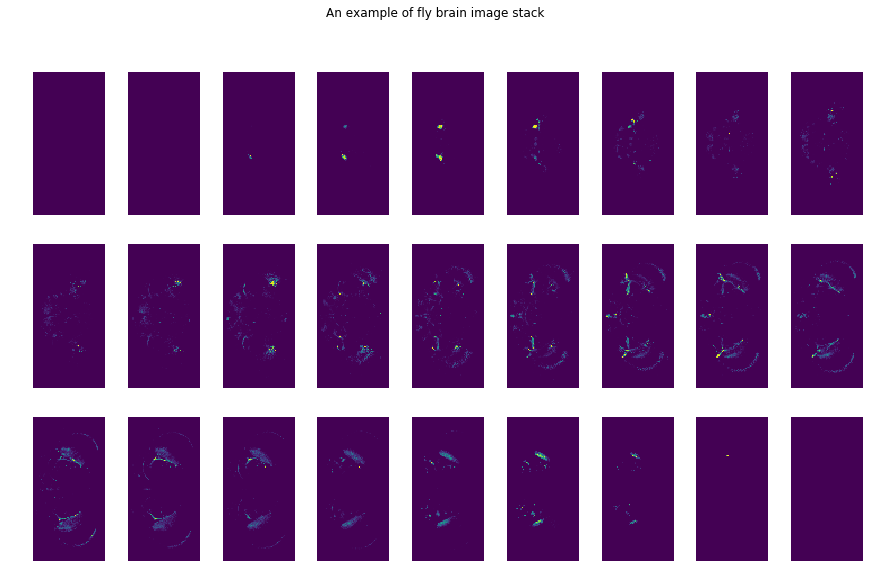

In [0]:
# an example of brain image
plot_image(data[3,:,:,:], 'An example of fly brain image stack')

There are a total of 27 optical sections that cover the whole fly brain. Starting from the top left (anterior end) to bottom right (posterior end).  

## II. Test performance of CNN on artificial data
In this project, I am interested in using CNN to identify any brain region that is related to specific behavior. To see whether CNN can actually locate features that exist in the positive groups but absence in the negative group, I insert a single pixel in a small regioin of the brain image (8x4x4). Then I test the performance of a basic CNN on this classification task. Next, I apply grad-CAM to see whether the CNN model can actually tell us what regions in the brain are important.

### IIa. Create artificial data with added neuron

In [0]:
# function to add random pixel in the first half of image stacks
# img- image stack where pixel is added to the first half
# x,y,z- location where the pixel is added
# intensity- lowest intensity of the pixel
# offset - a range where the pixel be located 
#
def add_neuron(img, x, y, z, intensity, offset, s):
  random.seed(s)
  
  for i in range(img.shape[0]//2):
    X = random.randint(x,x+2*offset)     
    Y = random.randint(y,y+offset)     
    Z = random.randint(z,z+offset)      
  
    img[i, X, Y, Z] = random.randint(intensity,255) 
    
  # create label 
  label = np.zeros(img.shape[0])
  label[img.shape[0]//2:] = 1  
    
  return img, label

In [0]:
# create shuffled index for whole dataset
np.random.seed(11)

index = np.arange(data.shape[0])
np.random.shuffle(index)

In [0]:
# add one neuron to specific location in the brain stack
modDat, target = add_neuron(data[index, :,:,:], x=60, y=30, z=10, intensity=150, offset=4, s=1)

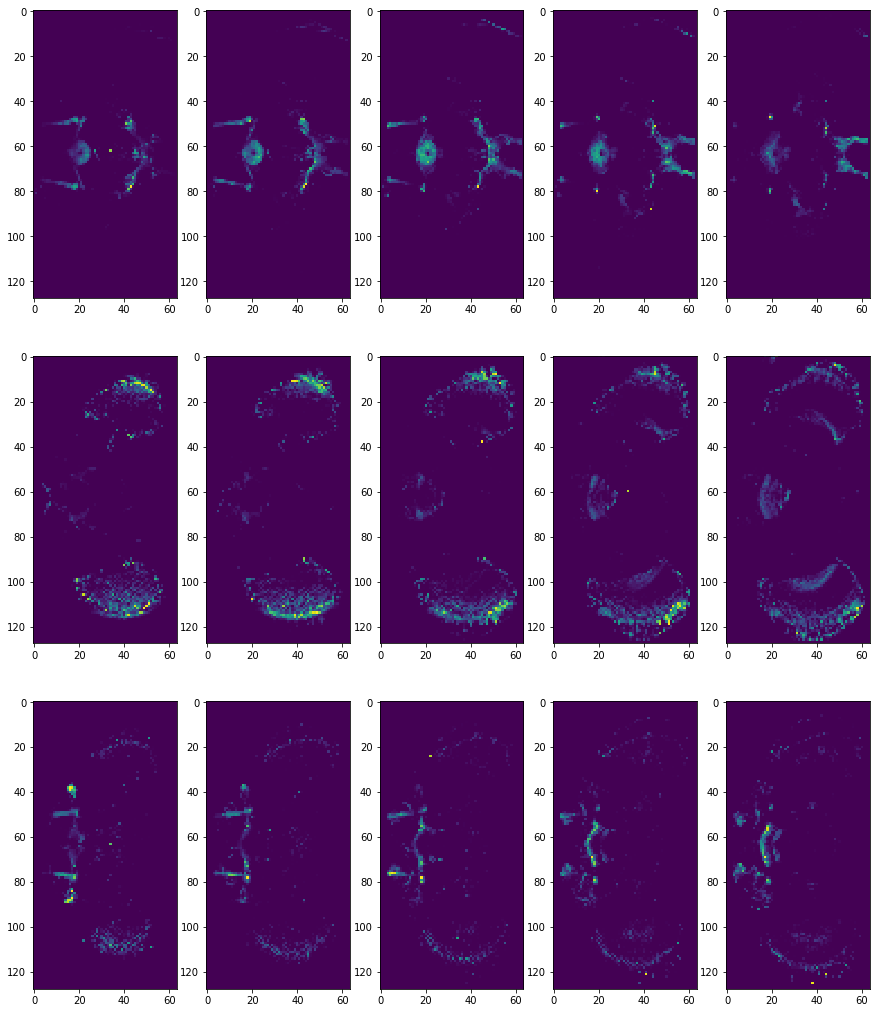

In [0]:
# show where the additional neuron is on the images
plt.figure(figsize=(15,18)) 
for iteration in range(5):
    plt.subplot(3, 5, iteration + 1)
    plt.imshow(modDat[0,:,:,iteration+10])
    plt.subplot(3, 5, iteration + 6)
    plt.imshow(modDat[3,:,:,iteration+10])
    plt.subplot(3, 5, iteration + 11)
    plt.imshow(modDat[5,:,:,iteration+10])
plt.show()

Here are 3 examples of brain images with an additional pixel representing a neuron. Top: slice 1 ~(60,34), Middle: slice 4 ~(60,30), Bottom: slice 1 ~(58,34)

In [0]:
# function to generate training dataset
def create_train_test(img, label, ratio):
  # convert to 1 + 4D space (1st argument represents number of rows in the dataset)
  img = img/255
  xtrain = img.reshape(img.shape[0], 128, 64, 27, 1)

  # shuffle whole dataset so the validation data won't be all negative 
  idx = np.arange(label.shape[0])
  np.random.shuffle(idx)

  xtrain = xtrain[idx]
  ytrain = label[idx]
  
  # split data according to ratio
  r = int(len(ytrain)*(1-ratio))
  
  return xtrain[:r], ytrain[:r], xtrain[r:], ytrain[r:]

In [0]:
# create training dataset
np.random.seed(1)
xtrain, ytrain, xtest, ytest = create_train_test(modDat, target, 0.1)

### IIb. Create 3D-CNN model

In [9]:
# build a basic 3 layer 3D-CNN
from keras.layers import Input, Conv3D, MaxPool3D, Flatten, Dropout, Dense
from keras.losses import binary_crossentropy
from keras.models import Model
from keras.utils import plot_model

# create model
imgStack = Input(shape=(128,64,27,1))

conv1 = Conv3D(16, kernel_size=(3, 3, 3), activation='relu')(imgStack)
pool1 = MaxPool3D(pool_size=(2,2,2))(conv1)

conv2 = Conv3D(32, kernel_size=(3, 3, 3), activation='relu')(pool1)
pool2 = MaxPool3D(pool_size=(2,2,2))(conv2)

conv3 = Conv3D(64, kernel_size=(3, 3, 3), activation='relu')(pool2)
pool3 = MaxPool3D(pool_size=(2,2,2))(conv3)

flat1 = Flatten()(pool3)
hidden1 = Dense(128, activation='relu')(flat1)
drop1 = Dropout(0.4)(hidden1)
hidden2 = Dense(32, activation='relu')(drop1)
output = Dense(1, activation='sigmoid')(hidden2)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
# compile model
model = Model(inputs=imgStack, outputs=output)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 64, 27, 1)    0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 126, 62, 25, 16)   448       
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 63, 31, 12, 16)    0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 61, 29, 10, 32)    13856     
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 30, 14, 5, 32)     0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 28, 12, 3, 64)     55360     
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 14, 6, 1, 64)      0         
__________

In [0]:
# save model weight to allow comparison
model.save_weights(path+'model.h5')

In [0]:
# load untrained model and start training with added neuron in particular region
model.load_weights(path+'model.h5')
history = model.fit(xtrain, ytrain, batch_size=20, epochs=20, validation_data = (xtest,ytest))

Train on 429 samples, validate on 48 samples
Epoch 1/20
429/429 [==============================] - 4s 10ms/step - loss: 0.6967 - acc: 0.5012 - val_loss: 0.6944 - val_acc: 0.4583
Epoch 2/20
429/429 [==============================] - 4s 10ms/step - loss: 0.6936 - acc: 0.5501 - val_loss: 0.6883 - val_acc: 0.6250
Epoch 3/20
429/429 [==============================] - 4s 10ms/step - loss: 0.6832 - acc: 0.5874 - val_loss: 0.6574 - val_acc: 0.6042
Epoch 4/20
429/429 [==============================] - 4s 10ms/step - loss: 0.5761 - acc: 0.7413 - val_loss: 0.3386 - val_acc: 0.8958
Epoch 5/20
429/429 [==============================] - 4s 10ms/step - loss: 0.1965 - acc: 0.9580 - val_loss: 0.1196 - val_acc: 0.9583
Epoch 6/20
429/429 [==============================] - 4s 10ms/step - loss: 0.0432 - acc: 0.9930 - val_loss: 0.0663 - val_acc: 0.9792
Epoch 7/20
429/429 [==============================] - 4s 10ms/step - loss: 0.0235 - acc: 0.9930 - val_loss: 0.0044 - val_acc: 1.0000
Epoch 8/20
429/429 [====

In [0]:
# function for plotting train and validation accuracy
def plot_history(hist, epochs):
  acc = hist.history['acc']
  val_acc = hist.history['val_acc']
  ep = range(1, len(acc) + 1)

  plt.plot(ep, acc, 'b', label='Training acc')
  plt.plot(ep, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xticks(np.arange(0, epochs+1, step=epochs/10))
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.show()

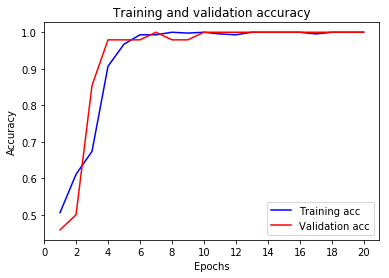

In [0]:
# plot result
plot_history(history, 20)

With a single pixel (neuron) added to random brain images at slightly different location. A simple 3 layers CNN can detect it with 100% accuracy. 

### IIc. Visualization of CNN result
Next, I want to find out what brain region is recognised by the CNN model as important. To do that, I generate heatmap for all positive images in the test dataset. Since the fly brain image data is standardized (same size, shape and dimension), I can average out the heatmap to obtain a region of interest (ROI). 

In [0]:
# perform grad-CAM
from keras import backend as K

mapping = model.output[:, 0]

# get output feature map of last conv layer
last_conv_layer = model.get_layer('conv3d_3')

# calculate gradient of output
grads = K.gradients(mapping, last_conv_layer.output)[0]

pooled_grads = K.mean(grads, axis=(0, 1, 2, 3))

iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

In [0]:
# function to create heatmap of a image stack
def create_heatmap(img, func, dim):
  # set heat map size to output size of last conv layer 
  hMap = np.zeros((img.shape[0],dim[0],dim[1],dim[2]))

  for i in range(img.shape[0]):
    pooled_grads_value, conv_layer_output_value = func([img[i:i+1,:,:,:]])

    for j in range(dim[3]):
      conv_layer_output_value[:, :, :, j] *= pooled_grads_value[j]
        
    tmp = np.mean(conv_layer_output_value, axis=-1)
    
    # normalize the heatmap
    hMap[i,:,:,:] = (tmp-np.amin(tmp))/(np.amax(tmp)-np.amin(tmp))
   
  return hMap

In [0]:
# create heatmap of all test data with target label
heatMap = create_heatmap(xtrain[ytrain==0], iterate, dim=[28,12,3, 64])

# find the mean value of all heat map of psoitive image to find the region of interest (ROI)
ROI = 1-np.mean(heatMap, axis=0)

# resize ROI back to original image size
ROI = zoom(ROI, (128/28, 64/12, 27/3))

# rescale ROI intensity and reduce background 
ROI = (np.maximum(ROI, 0.2)-0.2)*1.25

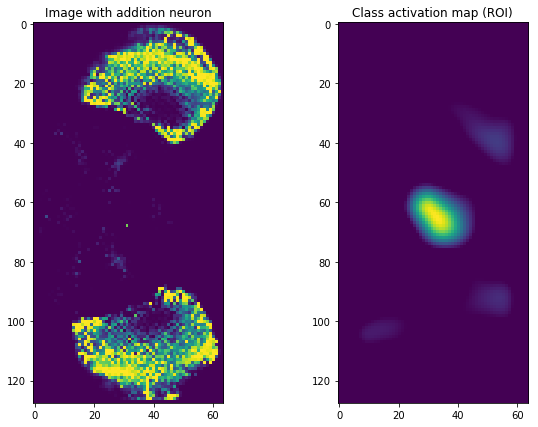

In [0]:
plt.figure(figsize=(10,7)) 
plt.subplot(1, 2, 1)
plt.imshow(np.amax(xtrain[9,:,:,10:15,0], axis=2))
plt.title('Image with addition neuron')
plt.subplot(1, 2, 2)
plt.imshow(ROI[:,:,13])
plt.title('Class activation map (ROI)')
plt.show()

The class activation map nicely with the addition neuron I added to image stacks. It shows that our CNN model can successfully identify a region of interest, which is related to the behavioral phenotype. 

### IId. Create artificial data with added neuron in random places
It is impressive to see 100% accuracy for a simple CNN model. Next, I would like to see how CNN performs if I added neuron in random places.

In [0]:
# add neuron to image stack in larger area
modDat, target = add_neuron(data[index, :,:,:], x=40, y=20, z=2, intensity=150, offset=23, s=1)

# create training dataset
xtrain, ytrain, xtest, ytest = create_train_test(modDat, target, 0.1)

In [0]:
# load untrained model and start training with added neuron in a random brain region
model.load_weights(path+'model.h5')
history = model.fit(xtrain, ytrain, batch_size=20, epochs=20, validation_data = (xtest,ytest))

Train on 429 samples, validate on 48 samples
Epoch 1/20
429/429 [==============================] - 4s 10ms/step - loss: 0.6938 - acc: 0.4685 - val_loss: 0.6870 - val_acc: 0.5625
Epoch 2/20
429/429 [==============================] - 4s 10ms/step - loss: 0.6945 - acc: 0.5268 - val_loss: 0.7004 - val_acc: 0.3750
Epoch 3/20
429/429 [==============================] - 4s 10ms/step - loss: 0.6926 - acc: 0.5152 - val_loss: 0.7031 - val_acc: 0.3750
Epoch 4/20
429/429 [==============================] - 4s 10ms/step - loss: 0.6917 - acc: 0.5245 - val_loss: 0.7003 - val_acc: 0.4167
Epoch 5/20
429/429 [==============================] - 4s 10ms/step - loss: 0.6905 - acc: 0.5455 - val_loss: 0.6961 - val_acc: 0.3958
Epoch 6/20
429/429 [==============================] - 4s 10ms/step - loss: 0.6873 - acc: 0.5524 - val_loss: 0.7143 - val_acc: 0.4167
Epoch 7/20
429/429 [==============================] - 4s 10ms/step - loss: 0.6955 - acc: 0.5245 - val_loss: 0.6973 - val_acc: 0.3958
Epoch 8/20
429/429 [====

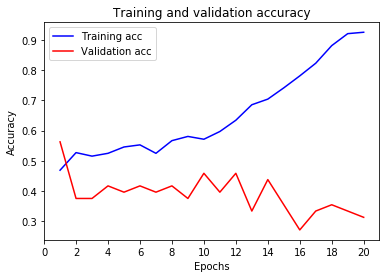

In [0]:
# plot result
plot_history(history, 20)

Since I add the neuron in random places, it is similar to noise and CNN model has difficulty identifying it. Training accuracy increases slowly and approach 100% as the model starts overfittng the data. On the other hands, validation accuracy drops gradually as overfitting occurs. 

## III. Identification of brain region regulating female chasing behavior
My experiment on hypothetical dataset suggests that CNN is fully capable of classifying brain image and identifies region of interest. In this section, I use the original brain image to analyze female chasing behavior. 

In fruit fly, chasing behavior is sexually dimorphic. Females rarely perform chasing, while males use it to establish dominant. It is to our interest to see what regions of brain control such behavior.  

### IIIa. Basic CNN model

In [0]:
# create label 
target = np.zeros(data.shape[0])
target[len(posList):] = 1  

# create train and test data
np.random.seed(12)

xtrain, ytrain, xtest, ytest = create_train_test(data, target, 0.1)

In [0]:
# run simple CNN model on original data
model.load_weights(path+'model.h5')
history = model.fit(xtrain, ytrain, batch_size=20, epochs=20, validation_data = (xtest,ytest))

Train on 429 samples, validate on 48 samples
Epoch 1/20
429/429 [==============================] - 6s 14ms/step - loss: 0.7058 - acc: 0.4755 - val_loss: 0.6923 - val_acc: 0.5625
Epoch 2/20
429/429 [==============================] - 4s 10ms/step - loss: 0.6929 - acc: 0.5268 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 3/20
429/429 [==============================] - 4s 10ms/step - loss: 0.6928 - acc: 0.5315 - val_loss: 0.6911 - val_acc: 0.6042
Epoch 4/20
429/429 [==============================] - 4s 10ms/step - loss: 0.6912 - acc: 0.5618 - val_loss: 0.6794 - val_acc: 0.5000
Epoch 5/20
429/429 [==============================] - 4s 10ms/step - loss: 0.6842 - acc: 0.5408 - val_loss: 0.6753 - val_acc: 0.4583
Epoch 6/20
429/429 [==============================] - 4s 10ms/step - loss: 0.6904 - acc: 0.5548 - val_loss: 0.6852 - val_acc: 0.5417
Epoch 7/20
429/429 [==============================] - 4s 10ms/step - loss: 0.6864 - acc: 0.5408 - val_loss: 0.6889 - val_acc: 0.5417
Epoch 8/20
429/429 [====

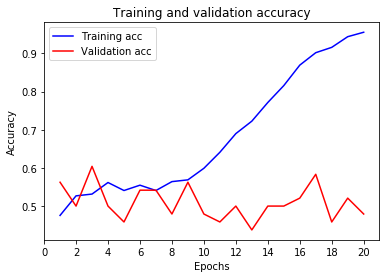

In [0]:
# plot result
plot_history(history, 20)

It looks like our basic CNN does not perform very well in this dataset. Validation accuracy reaches below 60% and gradually decline as the model start overfitting.

### IIIb. Data augmentation
To improve my model, I use data augmentation. Since the images are standardized, it may not be ideal to make drastic augmentation. However, as neurons usually exist bilaterally, I transform the original image with vertical flip as a simple data augmentation method.

In [0]:
# function to flip the brain images vertically
def flip_image(img):
  tmp = np.zeros(img.shape)
  for i in range(img.shape[2]):
    tmp[:,:,i,:] = np.flipud(img[:,:,i,:])
  
  return tmp

In [0]:
# create new train dataset with flipped images
X_train = flip_image(xtrain)
X_train = np.concatenate((X_train, xtrain), axis=0)

Y_train = np.concatenate((ytrain, ytrain), axis=0)

In [0]:
# run simple CNN model on augmented data
model.load_weights(path+'model.h5')
history = model.fit(X_train, Y_train, batch_size=20, epochs=20, shuffle=True, validation_data = (xtest,ytest))

Train on 858 samples, validate on 48 samples
Epoch 1/20
858/858 [==============================] - 8s 10ms/step - loss: 0.6958 - acc: 0.5000 - val_loss: 0.6909 - val_acc: 0.4375
Epoch 2/20
858/858 [==============================] - 8s 10ms/step - loss: 0.6925 - acc: 0.5093 - val_loss: 0.6975 - val_acc: 0.5625
Epoch 3/20
858/858 [==============================] - 8s 10ms/step - loss: 0.6915 - acc: 0.5000 - val_loss: 0.6941 - val_acc: 0.5625
Epoch 4/20
858/858 [==============================] - 8s 10ms/step - loss: 0.6827 - acc: 0.5571 - val_loss: 0.7220 - val_acc: 0.5833
Epoch 5/20
858/858 [==============================] - 8s 9ms/step - loss: 0.6764 - acc: 0.5793 - val_loss: 0.7134 - val_acc: 0.5208
Epoch 6/20
858/858 [==============================] - 8s 9ms/step - loss: 0.6732 - acc: 0.5956 - val_loss: 0.7253 - val_acc: 0.5625
Epoch 7/20
858/858 [==============================] - 8s 10ms/step - loss: 0.6682 - acc: 0.5781 - val_loss: 0.6940 - val_acc: 0.5208
Epoch 8/20
858/858 [======

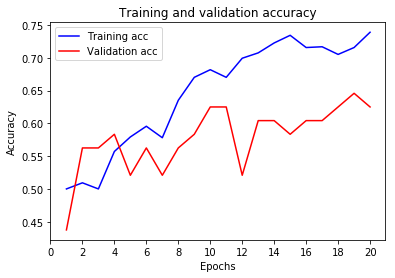

In [0]:
# plot result
plot_history(history, 20)

With augmented data, overfitting occurs later and much slower. Validation accuracy also improves to 60%..

### IIIc. Modification of model architecture
In an attempt to reduce overfitting and improve model accuracy, I add several dropout layers and modify the architecture of CNN.

In [0]:
# start a new graph
keras.backend.clear_session()

# build a new CNN model
imgStack = Input(shape=(128,64,27,1))

conv1a = Conv3D(8, kernel_size=(3, 3, 1), activation='relu')(imgStack)
conv1b = Conv3D(8, kernel_size=(3, 3, 3), activation='relu')(conv1a)
pool1 = MaxPool3D(pool_size=(2,2,2))(conv1b)
drop1 = Dropout(0.2)(pool1)

conv2a = Conv3D(16, kernel_size=(3, 3, 1), activation='relu')(drop1)
conv2b = Conv3D(16, kernel_size=(3, 3, 3), padding='same', activation='relu')(conv2a)
pool2 = MaxPool3D(pool_size=(2,2,2))(conv2b)
drop2 = Dropout(0.2)(pool2)

conv3a = Conv3D(32, kernel_size=(5, 3, 1), padding='same', activation='relu')(drop2)
conv3b = Conv3D(32, kernel_size=(5, 5, 3), padding='same', activation='relu')(conv3a)
pool3 = MaxPool3D(pool_size=(2,2,2))(conv3b)
drop3 = Dropout(0.2)(pool3)

flat1 = Flatten()(drop3)
hidden1 = Dense(64, activation='relu')(flat1)
drop4 = Dropout(0.5)(hidden1)
hidden2 = Dense(32, activation='relu')(drop4)
output = Dense(1, activation='sigmoid')(hidden2)

model = Model(inputs=imgStack, outputs=output)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 64, 27, 1)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 126, 62, 27, 8)    80        
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 124, 60, 25, 8)    1736      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 62, 30, 12, 8)     0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 62, 30, 12, 8)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 60, 28, 12, 16)    1168      
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 60, 28, 12, 16)    6928      
__________

In [0]:
history = model.fit(X_train, Y_train, batch_size=40, epochs=20, shuffle=True, validation_data = (xtest,ytest))

Train on 858 samples, validate on 48 samples
Epoch 1/20
858/858 [==============================] - 20s 23ms/step - loss: 0.6915 - acc: 0.5350 - val_loss: 0.6896 - val_acc: 0.6042
Epoch 2/20
858/858 [==============================] - 18s 21ms/step - loss: 0.6939 - acc: 0.5105 - val_loss: 0.6930 - val_acc: 0.5000
Epoch 3/20
858/858 [==============================] - 18s 20ms/step - loss: 0.6927 - acc: 0.5152 - val_loss: 0.6880 - val_acc: 0.5625
Epoch 4/20
858/858 [==============================] - 18s 21ms/step - loss: 0.6905 - acc: 0.5478 - val_loss: 0.6904 - val_acc: 0.5625
Epoch 5/20
858/858 [==============================] - 18s 21ms/step - loss: 0.6894 - acc: 0.5373 - val_loss: 0.6816 - val_acc: 0.6042
Epoch 6/20
858/858 [==============================] - 18s 20ms/step - loss: 0.6846 - acc: 0.5408 - val_loss: 0.6842 - val_acc: 0.5833
Epoch 7/20
858/858 [==============================] - 18s 21ms/step - loss: 0.6797 - acc: 0.5583 - val_loss: 0.6908 - val_acc: 0.6042
Epoch 8/20
858/85

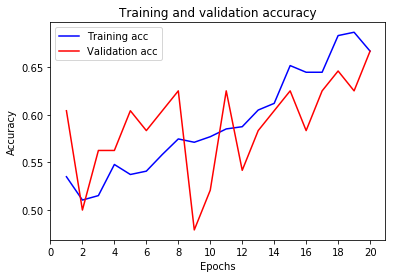

In [0]:
# plot result
plot_history(history, 20)

With the addition of conv and dropout layers, the problem of overfitting is reduced. Validation accuracy also increases to 65%. 

In [0]:
# save model weight 
model.save_weights(path+'model3.h5')

### IIId. Identification of regions related to female chasing behavior
Next, I would like to see whether this model can give us some information about regions of interest even though its accuracy is not too high. 

In [0]:
# using grad-CAM to identify region of interest
mapping = model.output[:, 0]

last_conv_layer = model.get_layer('conv3d_6')

from keras import backend as K
grads = K.gradients(mapping, last_conv_layer.output)[0]

pooled_grads = K.mean(grads, axis=(0, 1, 2, 3))

iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

In [0]:
# create heatmap of all test data with target label
heatMap = create_heatmap(xtrain[ytrain==0], iterate, [30,14,6,32])

# find the mean value of all heat map of psoitive image to find the region of interest (ROI)
ROI = 1-np.mean(heatMap, axis=0)

# resize ROI back to original image size
ROI = zoom(ROI, (128/30, 64/14, 27/6))

# rescale ROI intensity and reduce background 
ROI = (np.maximum(ROI, np.mean(ROI))-np.mean(ROI))*(2/(np.amax(ROI)-np.amin(ROI)))


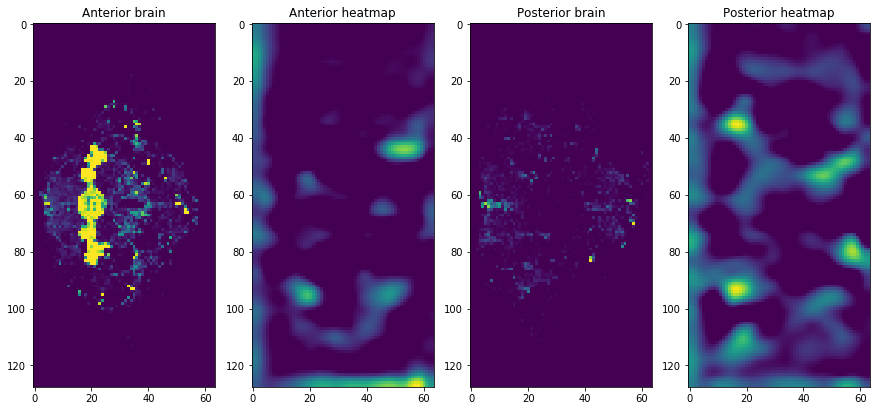

In [0]:
# comparing ROI and line with known female chasing phenotype
plt.figure(figsize=(15,7)) 
plt.subplot(1, 4, 1)
plt.imshow(np.amax(data[1,:,:,:14], axis=2))
plt.title('Anterior brain')
plt.subplot(1, 4, 2)
plt.imshow(ROI[:,:,7])
plt.title('Anterior heatmap')

plt.subplot(1, 4, 3)
plt.imshow(np.amax(data[1,:,:,14:27], axis=2)*2.3)
plt.title('Posterior brain')
plt.subplot(1, 4, 4)
plt.imshow(ROI[:,:,22])
plt.title('Posterior heatmap')
plt.show()

Heatmap of anterior brain does not match the brain image. Most of the highlighted areas are outside of the brain or in the optic lobe, which is expected to affects vision. However, the highlighted areas in the posterior brain regions are bilateral and more intriguing. Indeed, it does match some of the neurons we identified to be sexually dimorphic and female behavior.